# Tampa Real-Estate Recommender
## Feature Engineering
TB Real Estate Corporation is a real estate investment firm in the Tampa Bay, Florida area.  The real estate market in the Tampa Bay area is very active.  Single family homes are selling quickly.  TB Real Estate Corporation needs to be able to assess the value of homes coming onto the market quickly and accurately so that they can beat the competition in making a competitive offer.   They need to be able to evaluate the listing price against the predicted sale price in order to identify properties that may be priced below market value and would make good investments.  
<br>
The objective of the Feature Engineering is to prepare the features and to build training and testing datasets to optimally support the machine learning models in order to predict the sales price for residential properties.

# 1 Imports and File Locations<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

In [2]:
ext_data = '../data/external/'
raw_data = '../data/raw/'
interim_data = '../data/interim/'
report_figures = '../reports/figures/'

# 2 Read Sales data into dataframe<a id='2'></a>

In [3]:
df = pd.read_csv(interim_data + 'sales_df.csv', dtype={'FOLIO': object, 'DOR_CODE': object, 'NBHC': object, 'SECTION_CD': object, 'TOWNSHIP_CD': object, 'RANGE_CD': object, 'MARKET_AREA_CD': object}, parse_dates=['S_DATE'])
df.info()

C:\Users\mkars\AppData\Local\Temp\ipykernel_34888\2366488356.py:1: DtypeWarning: Columns (27,28,29,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(interim_data + 'sales_df.csv', dtype={'FOLIO': object, 'DOR_CODE': object, 'NBHC': object, 'SECTION_CD': object, 'TOWNSHIP_CD': object, 'RANGE_CD': object, 'MARKET_AREA_CD': object}, parse_dates=['S_DATE'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799380 entries, 0 to 799379
Data columns (total 42 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   FOLIO            799380 non-null  object        
 1   DOR_CODE         799380 non-null  object        
 2   S_DATE           799380 non-null  datetime64[ns]
 3   VI               799380 non-null  object        
 4   QU               799380 non-null  object        
 5   REA_CD           799380 non-null  object        
 6   S_AMT            799380 non-null  float64       
 7   SUB              799380 non-null  object        
 8   S_TYPE           799380 non-null  object        
 9   ORIG_SALES_DATE  799380 non-null  object        
 10  SITE_ADDR        799325 non-null  object        
 11  SITE_CITY        799373 non-null  object        
 12  SITE_ZIP         799380 non-null  object        
 13  tBEDS            799380 non-null  float64       
 14  tBATHS           799

# 4 Select Features for Engineering<a id='4'></a>

In [4]:
# Replace S_DATE with integer sales date epoch
df['sales_date_epoch'] = (df['S_DATE'] - dt.datetime(1970,1,1)).dt.days

In [5]:
# df['NBHC'] = pd.to_numeric(df['NBHC'])
# df.info()

In [6]:
# Filter for only Single Family Residential Homes ('0100')
df = df[df['DOR_CODE'] == '0100']

In [7]:
# Filter for current Sale Dates
df = df[(df['S_DATE'] >= '2020-01-01') & (df['S_DATE'] < '2021-01-01')]

In [8]:
# Filter for Market Area Code
df = df[df['MARKET_AREA_CD'] == '26']

In [9]:
# Filter for number of Bedrooms, Bathrooms, Buildings, Units, and Stories
df = df[(df['tBEDS'] >= 3) & (df['tBEDS'] <= 5)]
df = df[(df['tBATHS'] >= 1) & (df['tBATHS'] <= 4)]
df = df[df['tBLDGS'] == 1]
df = df[df['tUNITS'] == 1]
df = df[(df['tSTORIES'] >= 1) & (df['tSTORIES'] <= 2)]

In [10]:
# Filter for Age of Home at time of Sale
df = df[df.AGE < 20]

In [11]:
# Extract independent feature variables to X
features = ['FOLIO', 'S_DATE', 'SUB', 'sales_date_epoch', 'AGE', 'tBEDS', 'tBATHS', 'HEAT_AR', 'ACREAGE', 'NBHC']
X = df[features] 

In [12]:
# One-Hot encode NBHC
X = pd.get_dummies(X, columns=['NBHC'], prefix='NBHC')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 292622 to 520429
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FOLIO             3787 non-null   object        
 1   S_DATE            3787 non-null   datetime64[ns]
 2   SUB               3787 non-null   object        
 3   sales_date_epoch  3787 non-null   int64         
 4   AGE               3787 non-null   int64         
 5   tBEDS             3787 non-null   float64       
 6   tBATHS            3787 non-null   float64       
 7   HEAT_AR           3787 non-null   float64       
 8   ACREAGE           3787 non-null   float64       
 9   NBHC_226001.0     3787 non-null   uint8         
 10  NBHC_226002.0     3787 non-null   uint8         
 11  NBHC_226003.0     3787 non-null   uint8         
 12  NBHC_226004.0     3787 non-null   uint8         
 13  NBHC_226005.0     3787 non-null   uint8         
 14  NBHC_226006.0    

In [13]:
# Extract target dependent variable to y
y = df.S_AMT

In [14]:
# Call train_test_split on X, y. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3029, 24) (3029,)
(758, 24) (758,)


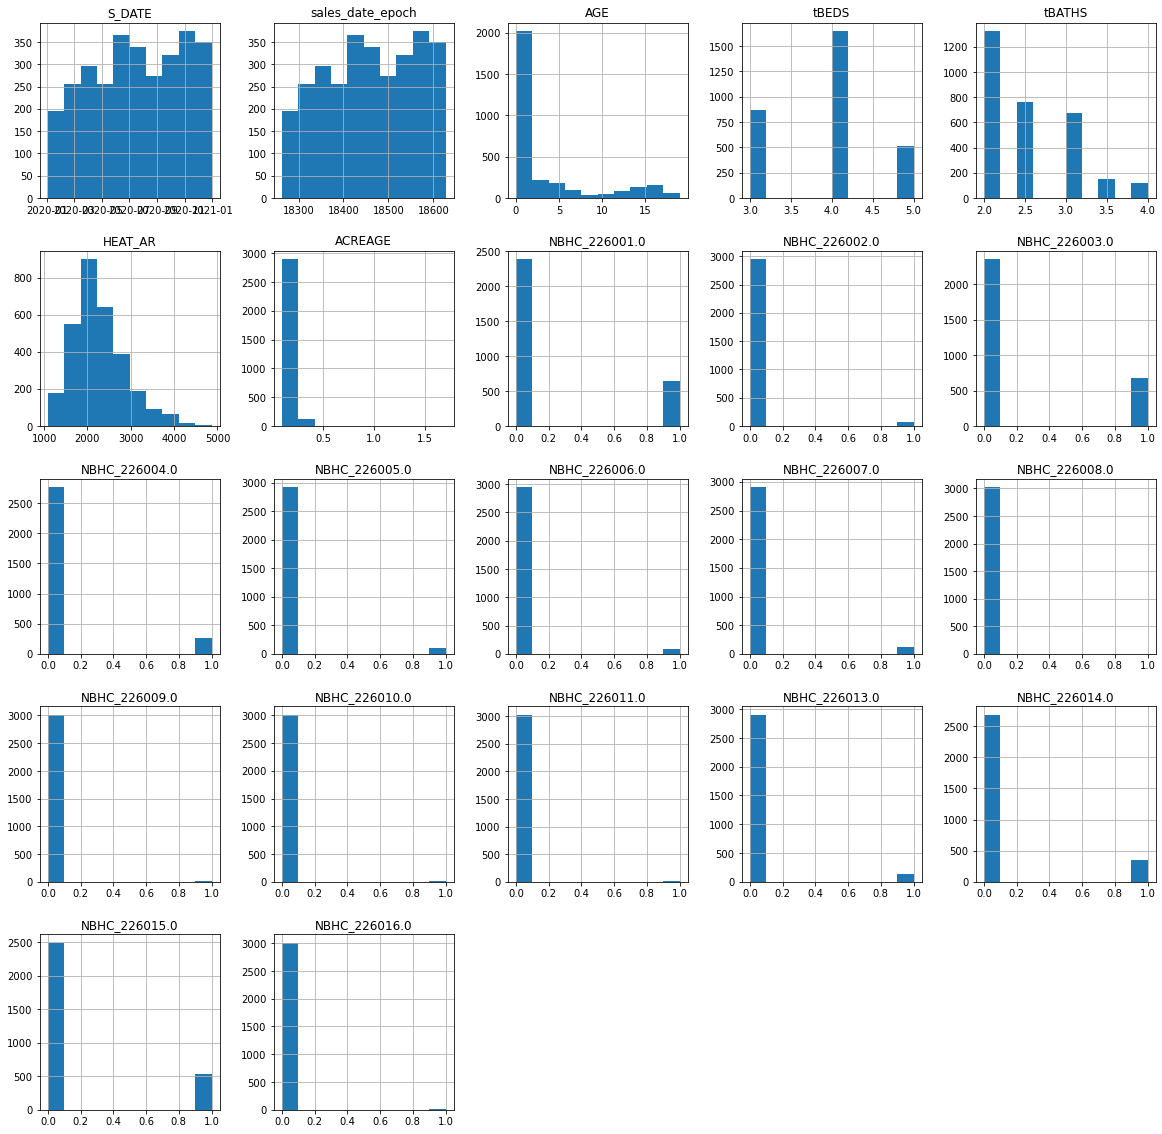

In [15]:
X_train.hist(figsize=(20, 20))
plt.show()

# 5 Encode Features<a id='5'></a>

Hash Encode the Subdivision Code

In [16]:
ce_target = ce.TargetEncoder()
X_train['SUB_encoded'] = ce_target.fit_transform(X_train['SUB'], y_train)
X_train.drop('SUB', axis=1, inplace=True)
X_train.head()

C:\Users\mkars\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


,FOLIO,S_DATE,sales_date_epoch,AGE,tBEDS,tBATHS,HEAT_AR,ACREAGE,NBHC_226001.0,NBHC_226002.0,...,NBHC_226007.0,NBHC_226008.0,NBHC_226009.0,NBHC_226010.0,NBHC_226011.0,NBHC_226013.0,NBHC_226014.0,NBHC_226015.0,NBHC_226016.0,SUB_encoded
517346,0779526760,2020-09-28,18533,0,3.0,2.0,1704.0,0.149074,1,0,...,0,0,0,0,0,0,0,0,0,221576.190599
514173,0777752562,2020-05-13,18395,0,4.0,2.0,1935.0,0.161241,1,0,...,0,0,0,0,0,0,0,0,0,244865.600000
516915,0779526026,2020-12-22,18618,13,3.0,2.0,1252.0,0.182550,1,0,...,0,0,0,0,0,0,0,0,0,228485.714286
517739,0779527472,2020-05-29,18411,0,5.0,2.5,2415.0,0.102192,1,0,...,0,0,0,0,0,0,0,0,0,217959.036145
465979,0767203242,2020-07-17,18460,0,3.0,2.0,2017.0,0.137803,0,0,...,0,0,0,0,0,0,0,0,0,301993.743662


In [17]:
X_test['SUB_encoded'] = ce_target.transform(X_test['SUB'])
X_test.drop('SUB', axis=1, inplace=True)
X_test.head()

,FOLIO,S_DATE,sales_date_epoch,AGE,tBEDS,tBATHS,HEAT_AR,ACREAGE,NBHC_226001.0,NBHC_226002.0,...,NBHC_226007.0,NBHC_226008.0,NBHC_226009.0,NBHC_226010.0,NBHC_226011.0,NBHC_226013.0,NBHC_226014.0,NBHC_226015.0,NBHC_226016.0,SUB_encoded
493588,0774793570,2020-07-16,18459,10,4.0,2.5,2041.0,0.160965,0,0,...,0,0,0,0,0,0,0,0,0,261281.256116
504747,0776941730,2020-12-17,18613,0,3.0,2.0,1561.0,0.137741,0,0,...,0,0,0,0,0,0,1,0,0,237494.990774
475192,0770576768,2020-03-03,18324,12,3.0,2.0,1557.0,0.137741,0,0,...,1,0,0,0,0,0,0,0,0,241655.351395
510923,0777212182,2020-11-12,18578,16,4.0,2.5,1927.0,0.118218,0,0,...,0,0,0,0,0,0,0,1,0,232827.358724
500856,0776850250,2020-02-06,18298,3,4.0,3.0,2040.0,0.131455,0,0,...,0,0,0,0,0,1,0,0,0,298619.500181


ce_hash = ce.HashingEncoder(cols = ['SUB'])
X_train = ce_hash.fit_transform(X_train)
X_train.head()

X_test = ce_hash.transform(X_test)
X_test.head()

# 6 Scale Features<a id='6'></a>

In [18]:
num_cols = X_train.select_dtypes(include=np.number).columns
num_cols

Index(['sales_date_epoch', 'AGE', 'tBEDS', 'tBATHS', 'HEAT_AR', 'ACREAGE',
       'NBHC_226001.0', 'NBHC_226002.0', 'NBHC_226003.0', 'NBHC_226004.0',
       'NBHC_226005.0', 'NBHC_226006.0', 'NBHC_226007.0', 'NBHC_226008.0',
       'NBHC_226009.0', 'NBHC_226010.0', 'NBHC_226011.0', 'NBHC_226013.0',
       'NBHC_226014.0', 'NBHC_226015.0', 'NBHC_226016.0', 'SUB_encoded'],
      dtype='object')

In [19]:
# Apply a standard scaler to the training data
X_train_scaled = X_train
SS_scaler = StandardScaler()
X_train_scaled[num_cols] = SS_scaler.fit_transform(X_train_scaled[num_cols])

In [20]:
X_test_scaled = X_test
X_test_scaled[num_cols] = SS_scaler.transform(X_test_scaled[num_cols])

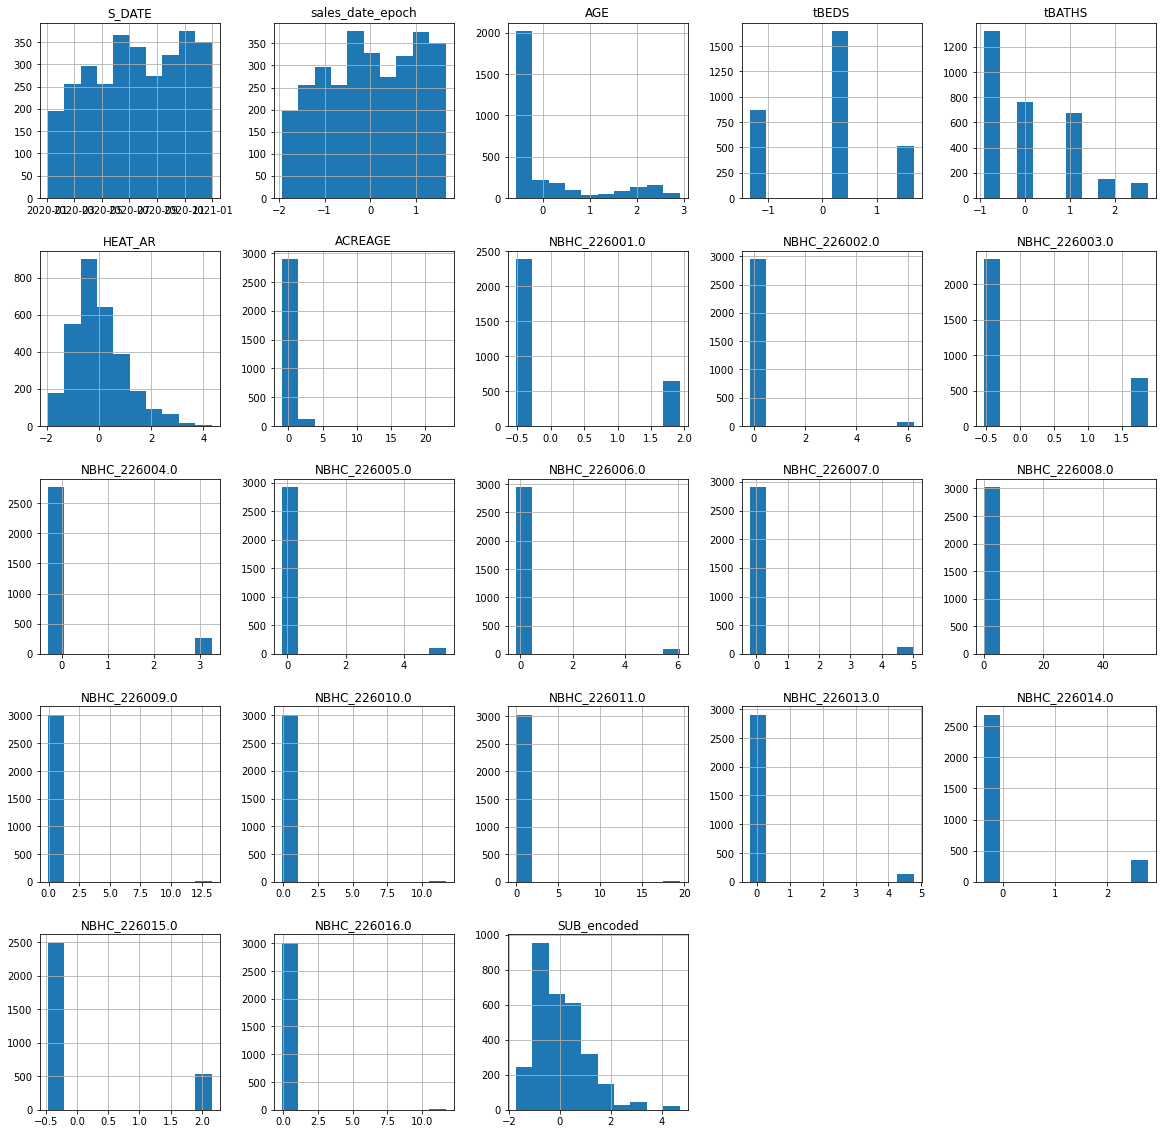

In [21]:
X_train_scaled.hist(figsize=(20, 20))
plt.show()

# 7 Export Train and Test Data to CSV<a id='7'></a>

In [22]:
# Save unscaled data to interim data folder as csv files
X_train.to_csv(interim_data + 'X_train.csv', index=False)
X_test.to_csv(interim_data + 'X_test.csv', index=False)
y_train.to_csv(interim_data + 'y_train.csv', index=False)
y_test.to_csv(interim_data + 'y_test.csv', index=False)

In [23]:
# Save unscaled data to interim data folder as csv files
X_train_scaled.to_csv(interim_data + 'X_train_scaled.csv', index=False)
X_test_scaled.to_csv(interim_data + 'X_test_scaled.csv', index=False)